In [45]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity as cs
from nltk.stem import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import pandas as pd
import re
import nltk as nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rachanathota/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rachanathota/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachanathota/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
#Read the input files

with open('test_file.txt', "r") as fr2:
        test_data = fr2.readlines()
        
train_data = pd.read_csv ('train_file.txt', sep="\t")

In [51]:
#pre-processing the data. The function to convert a raw review into string of words.

def preprocessor(Sentences):
    processed_features = []
    
    for sentence in range(0, len(Sentences)):
        
        #removes special characters
        clean = re.compile('<.*?>')
        processed_feature = re.sub(clean, '', str(Sentences[sentence]))

        processed_feature = re.sub(r'([\w\.-]+@[\w\.-]+\.\w+)','',processed_feature)
        processed_feature = re.sub(r'^https?:\/\/.*[\r\n]*', '', processed_feature, flags=re.MULTILINE)

        clean = re.compile('<.*?>')
        processed_feature = re.sub(clean, '', processed_feature)
        
        processed_feature = re.sub(r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]| \
        [a-z0-9.\-]+[.][a-z]{2,4}/|[a-z0-9.\-]+[.][a-z])(?:[^\s()<>]+|\(([^\s()<>]+| \
        (\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))','', processed_feature)

        # into lower case
        processed_feature = processed_feature.lower() 
    
        # 4. Tokenizing
        processed_feature = processed_feature.split()
    
        # 5. In Python, searching a set is much faster than searching a list, so convert the stop words to a set
        stops = set(stopwords.words("english"))                      
    
        # 6. Remove stop words. Restrict length grater than 3. Lematize and Stem
        lemmatizer = WordNetLemmatizer()
        ps = PorterStemmer()
        lemmatized_words = ''
        for word in processed_feature:
            if word not in stops and len(word) > 3:
                lemma = str(lemmatizer.lemmatize(word))
                stem = ps.stem(lemma)
                lemmatized_words += str(lemmatizer.lemmatize(stem))
                lemmatized_words += ' '
        processed_features.append(lemmatized_words)
    
    # 7. Returning the processed text
    return processed_features              
    

In [52]:
#pre-processing the train data
preprocessed_train_data = preprocessor(train_data.review)

In [53]:
preprocessed_train_data

["review mention watch episod hooked. right, exactli happen first thing struck brutal unflinch scene violence, right word trust show faint heart timid. show pull punch regard drugs, violence. hardcore, classic word.it call nicknam given oswald maximum secur state penitentary. focu mainli emerald city, experiment section prison cell glass front face inwards, privaci high agenda. citi home muslims, gangstas, latinos, christians, italians, irish more....so scuffles, death stares, dodgi deal shadi agreement never away.i would main appeal show fact go show dare. forget pretti pictur paint mainstream audiences, forget charm, forget romance...oz mess around. first episod ever struck nasti surreal, readi watch more, develop tast accustom high level graphic violence. violence, injustic (crook guard who'll sold nickel, inmat who'll kill order away well mannered, middl class inmat turn prison bitch lack street skill prison experience) watch becom comfort uncomfort touch darker side. ",
 'wonder l

In [54]:
len(preprocessed_train_data)

14999

In [55]:
#pre-processing the test data
preprocessed_test_data = preprocessor(test_data)

In [56]:
#This function returns L2-normalized sparse matrices with TF-IDF values
def TFIDFVectorizing(train_data, test_data):
    
    vectorizer = TfidfVectorizer(norm = 'l2')
    
    train_matrix = vectorizer.fit_transform(train_data)
    test_matrix = vectorizer.transform(test_data)

    return train_matrix, test_matrix

In [57]:
# TFIDF vectorizing
vectorizer = TfidfVectorizer(norm = 'l2')
    
train_matrix= vectorizer.fit_transform(preprocessed_train_data)
test_matrix = vectorizer.transform(preprocessed_test_data)


In [58]:
#this function computes cosine similarity between the two as a numpy array
similarities = cs(test_matrix, train_matrix)
len(similarities)

15000

In [59]:
#this function calculates the count of positive and negative reviews

def predict(nearestNeighbors, labels):
    positiveReviewsCount = 0
    negativeReviewsCount = 0
    for neighbor in nearestNeighbors:
        if int(labels[neighbor]) == 1:
            positiveReviewsCount += 1
        else:
            negativeReviewsCount += 1
    if positiveReviewsCount > negativeReviewsCount:
        return 1
    else:
        return -1

In [60]:
#this function calculates the score between the predicted sentiments and actual(y_test) sentiments

def get_score(X_train, X_test, y_train, y_test, k):
    test_sentiments = list()
    
    train_matrix, test_matrix = TFIDFVectorizing(X_train, X_test)
    similarities1 = cs(test_matrix, train_matrix)
    sents = [];
    correct = 0;
    for similarity in similarities1:
        knn = np.argsort(-similarity)[:k]
        prediction = predict(knn, train_data.sentiment)
    
       #To write to the list as +1 instead of just a 1 for positive reviews
        if prediction == 1:
            sents.append(1)
        else:
            sents.append(-1)
    correct = 0
    for x, y in zip(sents, y_test):
        if x == y:
            correct = correct + 1
    return(correct/len(y_test))


In [61]:
train=pd.DataFrame()
train['review']=preprocessed_train_data
train['sentiment']=train_data.sentiment
train

,review,sentiment
0,"review mention watch episod hooked. right, exa...",1
1,wonder littl production. film techniqu unassum...,1
2,"thought wonder spend time summer weekend, sit ...",1
3,basic there' famili littl (jake) think there' ...,-1
4,"petter mattei' ""love time money"" visual stun f...",1
...,...,...
14994,****yep! dress kill kind movie. like kaliforni...,1
14995,bobcat goldthwait commend attempt someth diffe...,-1
14996,"sinc day ""clarissa explain all"" i'v crush meli...",1
14997,travel coupl (horton hamilton)stumbl onto town...,-1


In [65]:
#K-fold
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf

#splits the train data into X_train, X_test, Y_train and Y_test
scores_k = []
k_range = range(300, 400)
avg1 = []
for k in range(300, 400, 10):
    scores_k = []
    for train_index, test_index in kf.split(train):
        X_train, X_test, y_train, y_test = train.review[train_index], train.review[test_index],train.sentiment[train_index], train.sentiment[test_index]
        scores = get_score(X_train, X_test, y_train, y_test, k)
        scores_k.append(scores)
        print('For value of k= '+str(k)+' the accuracy is : ' +str(scores))
        #print(scores)
    avg1.append(sum(scores_k)/len(scores_k))
    print('For value of k= '+str(k)+' the kfold accuracy is : ' +str(avg1))

For value of k= 300 the accuracy is : 0.5173333333333333
For value of k= 300 the accuracy is : 0.719
For value of k= 300 the accuracy is : 0.768
For value of k= 300 the accuracy is : 0.8156666666666667
For value of k= 300 the accuracy is : 0.8016005335111704
For value of k= 300 the kfold accuracy is : [0.724320106702234]
For value of k= 310 the accuracy is : 0.518
For value of k= 310 the accuracy is : 0.7266666666666667
For value of k= 310 the accuracy is : 0.774
For value of k= 310 the accuracy is : 0.8133333333333334
For value of k= 310 the accuracy is : 0.8026008669556519
For value of k= 310 the kfold accuracy is : [0.724320106702234, 0.7269201733911304]
For value of k= 320 the accuracy is : 0.524
For value of k= 320 the accuracy is : 0.725
For value of k= 320 the accuracy is : 0.774
For value of k= 320 the accuracy is : 0.8136666666666666
For value of k= 320 the accuracy is : 0.7992664221407135
For value of k= 320 the kfold accuracy is : [0.724320106702234, 0.7269201733911304, 0.72

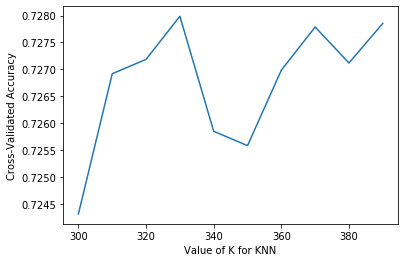

In [66]:
k_range = range(300, 400, 10)
# plot to see clearly
plt.plot(k_range, avg1)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [68]:
#KNN CLASSIFIER
#Pass every row in the numpy array of similarities to predict the sentiment of every review
k = 370
final_result = []

#here similarities is the cosine distance between train_matrix and test_matrix in cell number 58
for i in similarities:
    knn = np.argsort(-i)[:k]
    prediction = predict(knn, train_data.sentiment)
    
    #To write to the list as +1 instead of just a 1 for positive reviews
    if prediction == 1:
        final_result.append('1')
    else:
        final_result.append('-1')

In [69]:
#Write the result to a .txt file
output = open('output.txt', 'w')

output.writelines( "%s\n" % item for item in final_result )

output.close()
print('Finished')

Finished
